# 0. Import data from Kaggle

In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download uom190346a/sleep-health-and-lifestyle-dataset
!unzip sleep-health-and-lifestyle-dataset.zip

  0% 0.00/2.54k [00:00<?, ?B/s]
100% 2.54k/2.54k [00:00<00:00, 7.21MB/s]
Archive:  sleep-health-and-lifestyle-dataset.zip
  inflating: Sleep_health_and_lifestyle_dataset.csv  


# 1. Import neccesary libraries

In [ ]:
# General
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 2. Perform Data Exploration

In [ ]:
df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")

In [ ]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [ ]:
# Check the information about the DataFrame
print(df.info())

# Check for any missing values
print("\nMissing Values:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           374 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB
None

Missing Values:


There are no missing values in this dataset.

In [ ]:
# Get summary statistics of numerical columns
print("\nSummary Statistics For Numerical Columns:")
print(df.describe())

# Check unique values for categorical variables
print("\nUnique values in categorical variables:")
print("Gender:", df['Gender'].unique())
print("Occupation:", df['Occupation'].unique())
print("BMI Category:", df['BMI Category'].unique())
print("Sleep Disorder:", df['Sleep Disorder'].unique())


Summary Statistics For Numerical Columns:
        Person ID         Age  Sleep Duration  Quality of Sleep  \
count  374.000000  374.000000      374.000000        374.000000   
mean   187.500000   42.184492        7.132086          7.312834   
std    108.108742    8.673133        0.795657          1.196956   
min      1.000000   27.000000        5.800000          4.000000   
25%     94.250000   35.250000        6.400000          6.000000   
50%    187.500000   43.000000        7.200000          7.000000   
75%    280.750000   50.000000        7.800000          8.000000   
max    374.000000   59.000000        8.500000          9.000000   

       Physical Activity Level  Stress Level  Heart Rate   Daily Steps  
count               374.000000    374.000000  374.000000    374.000000  
mean                 59.171123      5.385027   70.165775   6816.844920  
std                  20.830804      1.774526    4.135676   1617.915679  
min                  30.000000      3.000000   65.000000   30

It looks like we will need some sort of scaling for the numerical columns. Also, it looks like occupation has a lot more values than other categorical columns. There are no typoes or errors to fix in the categorical variables.

In [ ]:
fig = ff.create_scatterplotmatrix(df[['Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Age', 'Stress Level', 'Sleep Disorder']], diag='histogram', index='Sleep Disorder', opacity=.8, height=1000, width=1000)
fig.show()

<Axes: xlabel='Gender'>

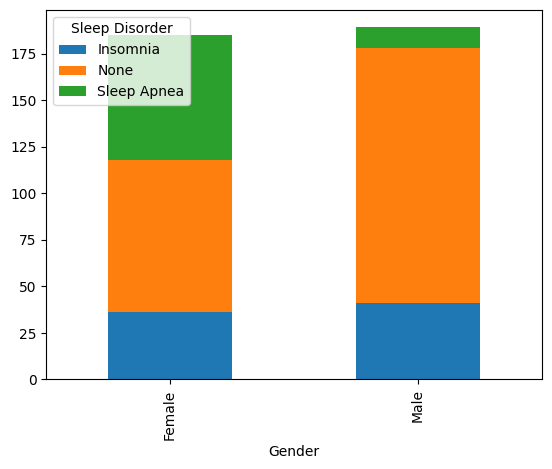

In [ ]:
grouped_df = df.groupby(['Gender', 'Sleep Disorder']).size().unstack(fill_value=0)
grouped_df.plot(kind='bar', stacked=True)

The categories that appear to be the most linearly correlated are: "Sleep Duration vs. Quality of Sleep", "Quality of Sleep vs Physical Activity Level" and "Quality of Sleep vs. Stress Level".

<Axes: xlabel='BMI Category'>

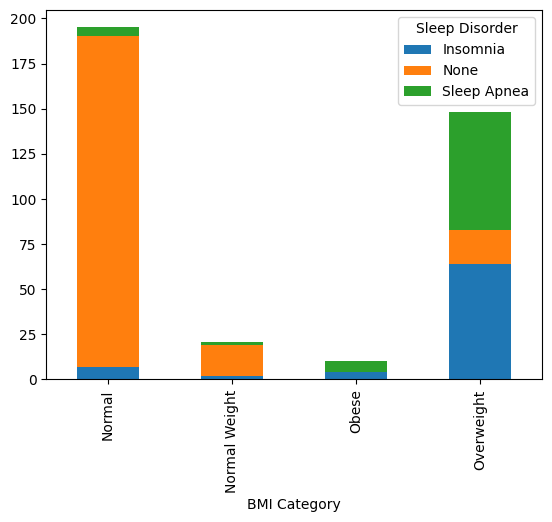

In [ ]:
grouped_df = df.groupby(['BMI Category', 'Sleep Disorder']).size().unstack(fill_value=0)
grouped_df.plot(kind='bar', stacked=True)

<Axes: xlabel='Occupation'>

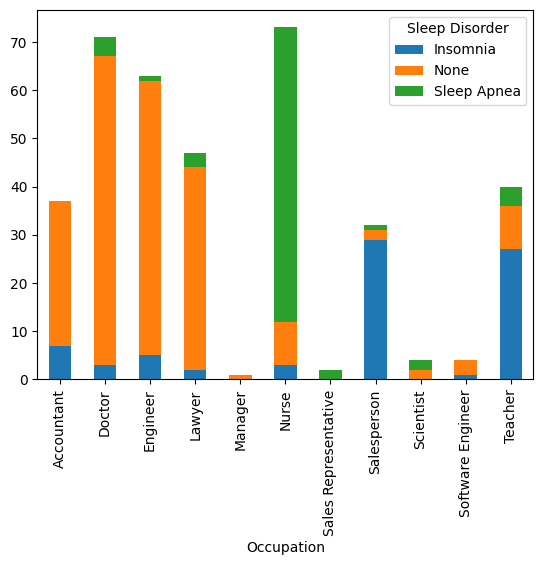

In [ ]:
grouped_df = df.groupby(['Occupation', 'Sleep Disorder']).size().unstack(fill_value=0)
grouped_df.plot(kind='bar', stacked=True)

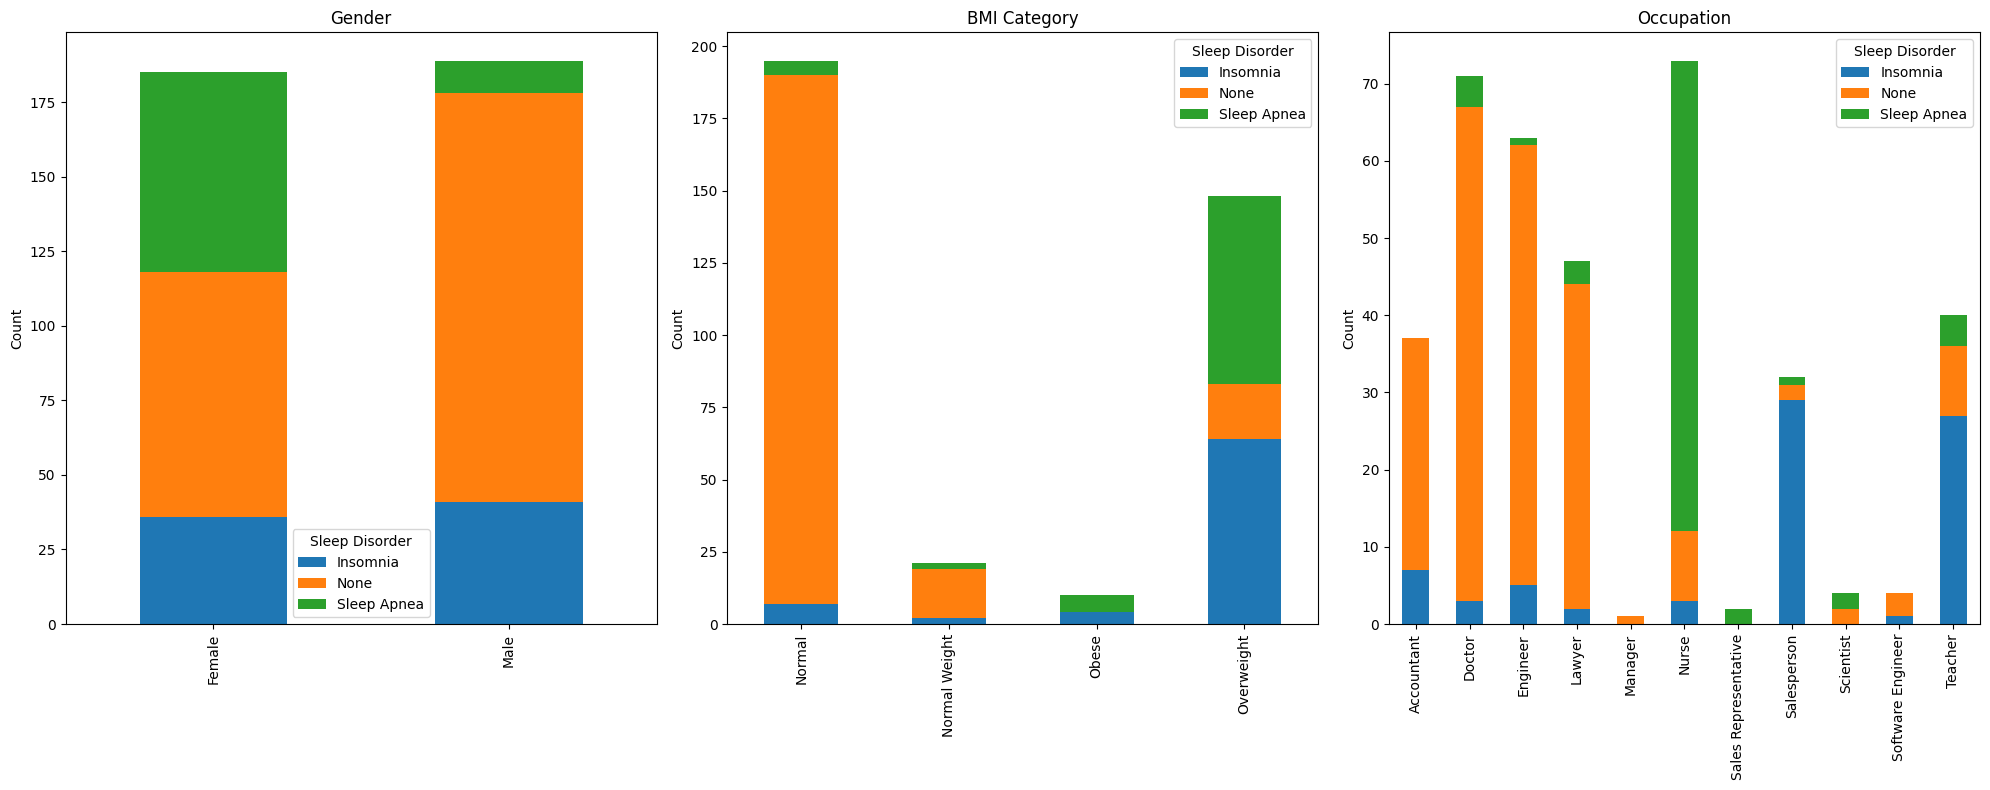

In [ ]:
categorical = ['Gender', 'BMI Category', 'Occupation']
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for i, ax in enumerate(axes.flatten()):
    if i < len(categorical):
        grouped_df = df.groupby([categorical[i], 'Sleep Disorder']).size().unstack(fill_value=0)
        grouped_df.plot(kind='bar', stacked=True, ax=ax)
        ax.set_title(categorical[i])
        ax.set_xlabel('')
        ax.set_ylabel('Count')
        ax.legend(title='Sleep Disorder')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
print("\nNumber of duplicate rows:", df.duplicated().sum())


Number of duplicate rows: 0


Since there are no duplicate rows, we don't need to worry about dealing with them.

# 3. Train machine learning models


3.1. First, we try logisitic regression


Try only considering Age, Sleep Duration, Quality of Sleep, Physical Activity Level, and Stress Level to predict a sleep disorder.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

sleep = pd.read_csv("/content/Sleep_health_and_lifestyle_dataset.csv")
sleep = sleep.drop(columns=['Person ID', 'Gender', 'BMI Category', 'Blood Pressure', 'Heart Rate', 'Daily Steps','Occupation'])
#print(sleep['Sleep Disorder'].unique())
sleep['Sleep Disorder'] = sleep['Sleep Disorder'].replace({'Sleep Apnea': 1, 'Insomnia': 2, 'None': 0})
sleep['Sleep Disorder'] = sleep['Sleep Disorder'].fillna(0)
print(sleep.head())

   Age  Sleep Duration  Quality of Sleep  Physical Activity Level  \
0   27             6.1                 6                       42   
1   28             6.2                 6                       60   
2   28             6.2                 6                       60   
3   28             5.9                 4                       30   
4   28             5.9                 4                       30   

   Stress Level  Sleep Disorder  
0             6               0  
1             8               0  
2             8               0  
3             8               1  
4             8               1  


In [ ]:
#split to train and test 80/20
train, test = train_test_split(sleep, test_size=0.2)
X_lr_train, y_lr_train = train.drop(columns=['Sleep Disorder']) ,train['Sleep Disorder']
X_lr_test, y_lr_test = test.drop(columns=['Sleep Disorder']), test['Sleep Disorder']

print(X_lr_train.shape, X_lr_test.shape)

(299, 5) (75, 5)


Overall Precision: 0.8711843711843712
Overall Recall: 0.7908496732026143
Overall F1-score: 0.8196969696969698
Overall Accuracy: 0.8533333333333334
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        40
           1       0.86      0.67      0.75        18
           2       0.92      0.71      0.80        17

    accuracy                           0.85        75
   macro avg       0.87      0.79      0.82        75
weighted avg       0.86      0.85      0.85        75



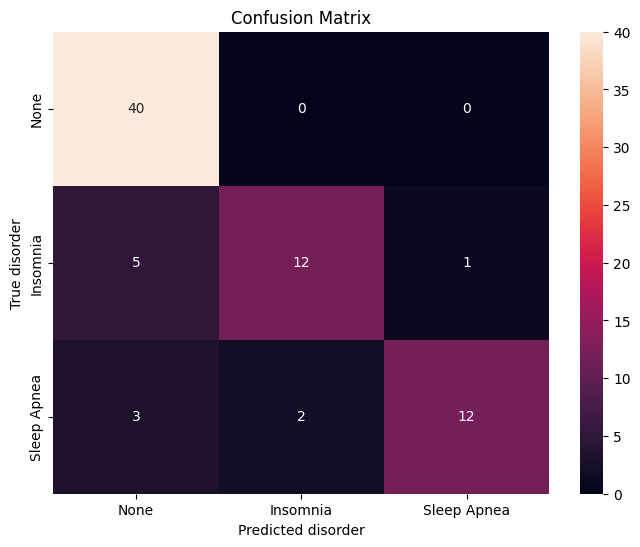

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

cls = LogisticRegression(max_iter=100000)
cls.fit(X_lr_train, y_lr_train)
predictions = cls.predict(X_lr_test)
report = classification_report(y_lr_test, predictions, output_dict=True)

# Print overall recall, precision, F1-score, and accuracy
print("Overall Precision:", report['macro avg']['precision'])
print("Overall Recall:", report['macro avg']['recall'])
print("Overall F1-score:", report['macro avg']['f1-score'])
print("Overall Accuracy:", report['accuracy'])
print(classification_report(y_lr_test, cls.predict(X_lr_test)))

class_labels = ['None', 'Insomnia', 'Sleep Apnea']
conf_matrix = confusion_matrix(y_lr_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=class_labels, yticklabels=class_labels, annot=True)
plt.xlabel('Predicted disorder')
plt.ylabel('True disorder')
plt.title('Confusion Matrix')
plt.show()

3.2. Try polynomial regression with degrees 2 - 6.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import operator

def activation(thing):
    for i in range(len(thing)):
        if thing[i] <= 0.5:
            thing[i] = 0
        elif thing[i] > 1.4:
            thing[i] = 2
        else:
            thing[i] = 1
    return thing

def process_tf(dataset1, dataset2, what):
    #both should be same length
    TP, FP, TN, FN = 0,0,0,0
    for i in range(len(dataset1)):
        if dataset1[i] == what and dataset2[i] == what:
            TP += 1
        elif dataset1[i] == what and dataset2[i] != what:
            FP += 1
        elif dataset1[i] != what and dataset2[i] != what:
            TN += 1
        elif dataset1[i] != what and dataset2[i] == what:
            FN +=1
    values = [TP, FP, TN, FN]
    return values

def calc_scores(values):
    #precision= TP/(TP + FP)
    print(values[0], values[1])
    precision = values[0]/(values[0] + values[1])
    recall = values[0]/(values[0] + values[3])
    f1score = 2 * precision * recall / (precision + recall)
    support = values[0] + values[3]
    accuracy = (values[0] + values[2])/(values[0] + values[1] + values[2] + values[3])
    to_return = [precision, recall, f1score,accuracy]
    to_return = [round(float(value), 4) for value in to_return]
    to_return.append(support)
    return to_return

def pol_reg_plot(degrees, X_test, y_test, X_train, y_train):
    poly = PolynomialFeatures(degree=degrees)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_pred_train = model.predict(X_train_poly)
    y_pred_test = model.predict(X_test_poly)
    y_activ_train = activation(y_pred_train)
    y_activ_test = activation(y_pred_test)
    my_list = y_test.tolist()
    print(f"degree {degrees}:")
    accuracies= []
    recalls = []
    for x in range(3):
        tf = process_tf(y_activ_test, my_list, x)
        print(tf)
        vals = calc_scores(tf)
        #0=prec, 1= recall, 2=f1score, 3= acc, support = 4
        print(f"for {x}, the values for precision, recall, accuracy, f1score, and support are as follows: {vals[0]}, {vals[1]}, {vals[3]}, {vals[2]}, {vals[4]}")
        accuracies.append(vals[3])
        recalls.append(vals[1])
    avg_acc = (accuracies[0] + accuracies[1] +accuracies[2])/3
    avg_rec = (recalls[0] + recalls[1] + recalls[2])/3
    print(f"average accuracy is {round(avg_acc, 4)} and average recall {round(avg_rec, 4)}")
    mse_train = mean_squared_error(y_train, y_activ_train)
    mse_test = mean_squared_error(y_test, y_activ_test)
    r2_train = r2_score(y_train, y_activ_train)
    r2_test = r2_score(y_test, y_activ_test)
    print(f"Mean Squared Error (Train): {mse_train:.2f}")
    print(f"Mean Squared Error (Test): {mse_test:.2f}")
    print(f"R-squared (Train): {r2_train:.2f}")
    print(f"R-squared (Test): {r2_test:.2f}")
    return model

models = []
for x in range(1,6):
    models.append(pol_reg_plot(x, X_lr_test, y_lr_test, X_lr_train, y_lr_train))


degree 1:
[37, 4, 31, 3]
37 4
for 0, the values for precision, recall, accuracy, f1score, and support are as follows: 0.9024, 0.925, 0.9067, 0.9136, 40
[14, 14, 43, 4]
14 14
for 1, the values for precision, recall, accuracy, f1score, and support are as follows: 0.5, 0.7778, 0.76, 0.6087, 18
[5, 1, 57, 12]
5 1
for 2, the values for precision, recall, accuracy, f1score, and support are as follows: 0.8333, 0.2941, 0.8267, 0.4348, 17
average accuracy is 0.8311 and average recall 0.6656
Mean Squared Error (Train): 0.36
Mean Squared Error (Test): 0.29
R-squared (Train): 0.44
R-squared (Test): 0.56
degree 2:
[38, 5, 30, 2]
38 5
for 0, the values for precision, recall, accuracy, f1score, and support are as follows: 0.8837, 0.95, 0.9067, 0.9157, 40
[13, 7, 50, 5]
13 7
for 1, the values for precision, recall, accuracy, f1score, and support are as follows: 0.65, 0.7222, 0.84, 0.6842, 18
[11, 1, 57, 6]
11 1
for 2, the values for precision, recall, accuracy, f1score, and support are as follows: 0.9

Based on the result, The most optimal degree is a degree 2 linear regression with the activation function, as it has the best avg accuracy and avg recall
of 92% and 87% respectively.

In [ ]:
def result_read(num):
    if num==0:
        print("no disorder")
    elif num==1:
        print("insomnia detected")
    else:
        print("sleep apnea detected")

In [ ]:
def test_model(age, dur, q, ph, s):
    the_model=models[1]
    data_test = {
    'Age': [age],
    'Sleep Duration': [dur],
    'Quality of Sleep': [q],
    'Physical Activity Level': [ph],
    'Stress Level': [s]
    }
    df_test = pd.DataFrame(data_test)
    df_pol = poly.fit_transform(df_test)
    predit = the_model.predict(df_pol)
    res = activation(predit)
    result_read(res)

In [ ]:
#test_model(28, 6, 5, 120, 6)#age, sleep dur, quality of sleep, activity level, stress level

3.3. Neural Network:

First, preprocess and normalize data.

In [ ]:
from sklearn.neural_network import MLPClassifier

X = df.drop(columns=['Sleep Disorder', 'Occupation', 'Gender', 'Person ID', 'BMI Category', 'Blood Pressure'], axis=1)
y = df['Sleep Disorder']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_rescaled = scaler.fit_transform(X_train)
X_test_rescaled = scaler.transform(X_test)

# Encoding the target variable
categories = [['None', 'Sleep Apnea', 'Insomnia']]
encoder = OneHotEncoder(categories=categories, sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

print("Pre-processed training data:")
print(pd.DataFrame(data=X_train_rescaled, columns=X.columns))
print("Pre-processed training class:")
print(y_train_encoded)

print("Pre-processed testing data:")
print(pd.DataFrame(data=X_test_rescaled, columns=X.columns))
print("Pre-processed testing class:")
print(y_test_encoded)

Pre-processed training data:
          Age  Sleep Duration  Quality of Sleep  Physical Activity Level  \
0    0.483871        0.259259               0.4                 0.250000   
1    0.161290        0.074074               0.4                 0.000000   
2    0.225806        0.629630               0.8                 0.500000   
3    1.000000        0.888889               1.0                 0.750000   
4    0.032258        0.259259               0.2                 0.166667   
..        ...             ...               ...                      ...   
294  0.161290        0.111111               0.4                 0.000000   
295  0.290323        0.111111               0.4                 0.200000   
296  0.677419        0.111111               0.4                 1.000000   
297  0.935484        0.888889               1.0                 0.750000   
298  0.258065        0.518519               0.8                 0.500000   

     Stress Level  Heart Rate  Daily Steps  
0            

In [ ]:
from sklearn.model_selection import GridSearchCV

max_iterations = [800,1100,1400]
hidden_layer_siz = [(16, 25), (14, 25), (25, 14)]
learning_rates = 0.15 * np.arange(1, 3)

param_grid = dict(learning_rate_init = learning_rates, hidden_layer_sizes = hidden_layer_siz, max_iter = max_iterations)
mlp = MLPClassifier(solver = 'sgd', random_state = 4, activation = 'logistic', learning_rate_init = 0.3, batch_size = 100, hidden_layer_sizes = (13, 23), max_iter = 500)
grid = GridSearchCV(estimator = mlp, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv = 10)

grid.fit(X_train_rescaled,y_train_encoded)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum

GridSearchCV(cv=10,
             estimator=MLPClassifier(activation='logistic', batch_size=100,
                                     hidden_layer_sizes=(13, 23),
                                     learning_rate_init=0.3, max_iter=500,
                                     random_state=4, solver='sgd'),
             param_grid={'hidden_layer_sizes': [(16, 25), (14, 25), (25, 14)],
                         'learning_rate_init': array([0.15, 0.3 ]),
                         'max_iter': [800, 1100, 1400]},
             scoring='neg_mean_squared_error')

Recall:  0.9066666666666666
Precision:  0.9054949494949495
F1 Score:  0.9058212829069338
Accuracy:  0.9066666666666666
Optimal Hyper-parameters :  {'hidden_layer_sizes': (14, 25), 'learning_rate_init': 0.15, 'max_iter': 800}
Optimal MSE :  0.06689655172413791
Support: 
               precision    recall  f1-score   support

    Insomnia       0.81      0.81      0.81        16
        None       0.95      0.98      0.97        43
 Sleep Apnea       0.87      0.81      0.84        16

    accuracy                           0.91        75
   macro avg       0.88      0.87      0.87        75
weighted avg       0.91      0.91      0.91        75



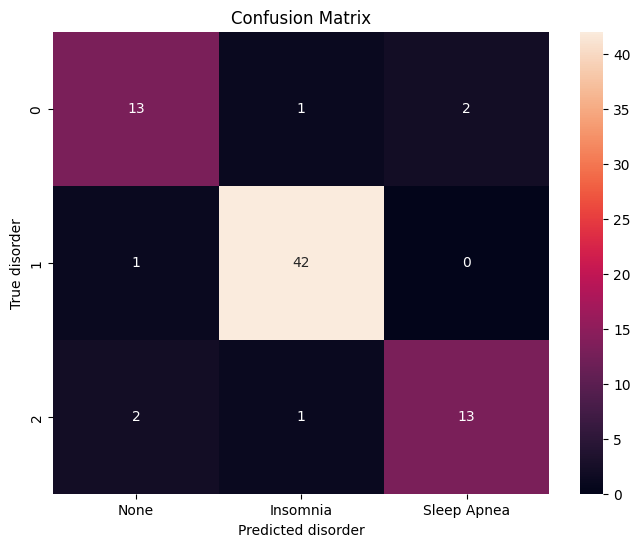

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report, accuracy_score

y_pred_encoded = grid.predict(X_test_rescaled)
y_pred = encoder.inverse_transform(y_pred_encoded)
y_true = encoder.inverse_transform(y_test_encoded)

# Calculate recall, precision, f1-score, support, and accuracy
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
support = classification_report(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

print("Recall: ", recall)
print("Precision: ", precision)
print("F1 Score: ", f1)
print("Accuracy: ", accuracy)
print("Optimal Hyper-parameters : ", grid.best_params_)
print("Optimal MSE : ", -1 * grid.best_score_)
print("Support: \n", support)

class_labels = ['None', 'Insomnia', 'Sleep Apnea']
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=class_labels, annot=True)
plt.xlabel('Predicted disorder')
plt.ylabel('True disorder')
plt.title('Confusion Matrix')
plt.show()

3.4. Decision tree


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_rescaled, y_train_encoded)

DecisionTreeClassifier(random_state=42)

Accuracy: 0.88
Precision: 0.8818596218596219
Recall: 0.88
F1-score: 0.8785395537525356
              precision    recall  f1-score   support

    Insomnia       0.72      0.81      0.76        16
        None       0.95      0.98      0.97        43
 Sleep Apnea       0.85      0.69      0.76        16

    accuracy                           0.88        75
   macro avg       0.84      0.83      0.83        75
weighted avg       0.88      0.88      0.88        75



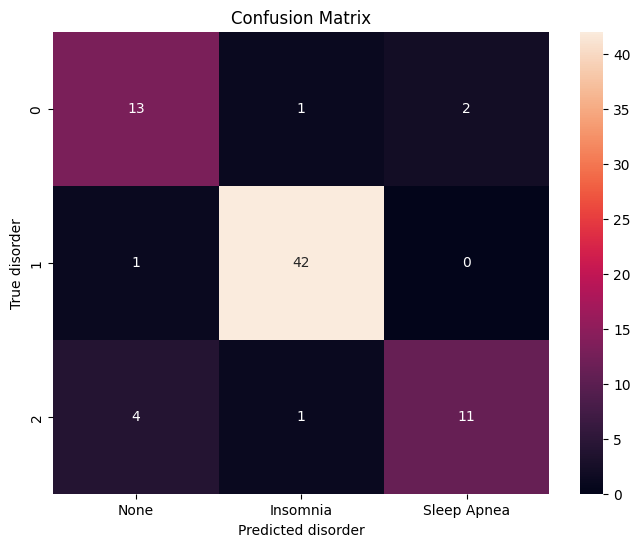

In [ ]:
y_pred = clf.predict(X_test_rescaled)

y_test_original = encoder.inverse_transform(y_test_encoded)
y_pred_original = encoder.inverse_transform(y_pred)

accuracy = accuracy_score(y_test_original, y_pred_original)
precision = precision_score(y_test_original, y_pred_original, average='weighted')
recall = recall_score(y_test_original, y_pred_original, average='weighted')
f1 = f1_score(y_test_original, y_pred_original, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print(classification_report(y_test_original, y_pred_original))

class_labels = ['None', 'Insomnia', 'Sleep Apnea']
conf_matrix = confusion_matrix(y_test_original, y_pred_original)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=class_labels, annot=True)
plt.xlabel('Predicted disorder')
plt.ylabel('True disorder')
plt.title('Confusion Matrix')
plt.show()

3.5. K-nearest neighbors model

KNN Metrics:
Accuracy: 0.88
Precision: 0.8818596218596219
Recall: 0.88
F1-score: 0.8785395537525356
              precision    recall  f1-score   support

    Insomnia       0.72      0.81      0.76        16
        None       0.95      0.98      0.97        43
 Sleep Apnea       0.85      0.69      0.76        16

    accuracy                           0.88        75
   macro avg       0.84      0.83      0.83        75
weighted avg       0.88      0.88      0.88        75



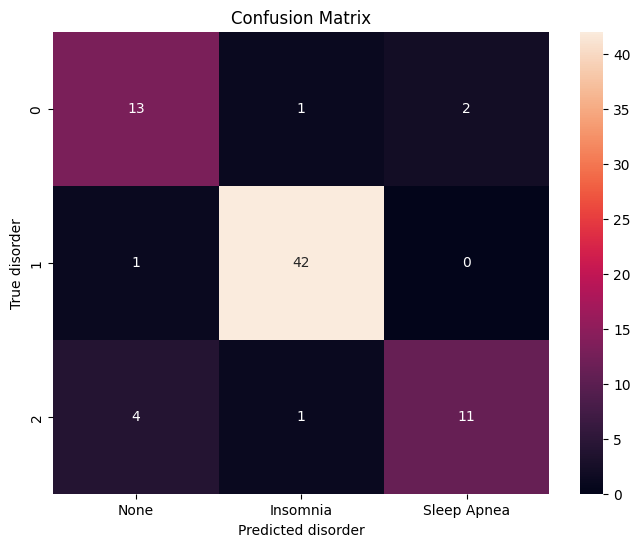

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

scaler_knn = StandardScaler()
X_train_scaled = scaler_knn.fit_transform(X_train)
X_test_scaled = scaler_knn.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

print("KNN Metrics:")
print("Accuracy:", accuracy_knn)
print("Precision:", precision_knn)
print("Recall:", recall_knn)
print("F1-score:", f1_knn)
print(classification_report(y_test, y_pred_knn))

class_labels = ['None', 'Insomnia', 'Sleep Apnea']
conf_matrix = confusion_matrix(y_test_original, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=class_labels, annot=True)
plt.xlabel('Predicted disorder')
plt.ylabel('True disorder')
plt.title('Confusion Matrix')
plt.show()

3.6. SVM


SVM Metrics for Kernel: linear
Accuracy: 0.9066666666666666
Precision: 0.9101217301217301
Recall: 0.9066666666666666
F1-score: 0.9058012170385397
              precision    recall  f1-score   support

    Insomnia       0.78      0.88      0.82        16
        None       0.95      0.98      0.97        43
 Sleep Apnea       0.92      0.75      0.83        16

    accuracy                           0.91        75
   macro avg       0.89      0.87      0.87        75
weighted avg       0.91      0.91      0.91        75


SVM Metrics for Kernel: poly
Accuracy: 0.88
Precision: 0.8818596218596219
Recall: 0.88
F1-score: 0.8785395537525356
              precision    recall  f1-score   support

    Insomnia       0.72      0.81      0.76        16
        None       0.95      0.98      0.97        43
 Sleep Apnea       0.85      0.69      0.76        16

    accuracy                           0.88        75
   macro avg       0.84      0.83      0.83        75
weighted avg       0.88      

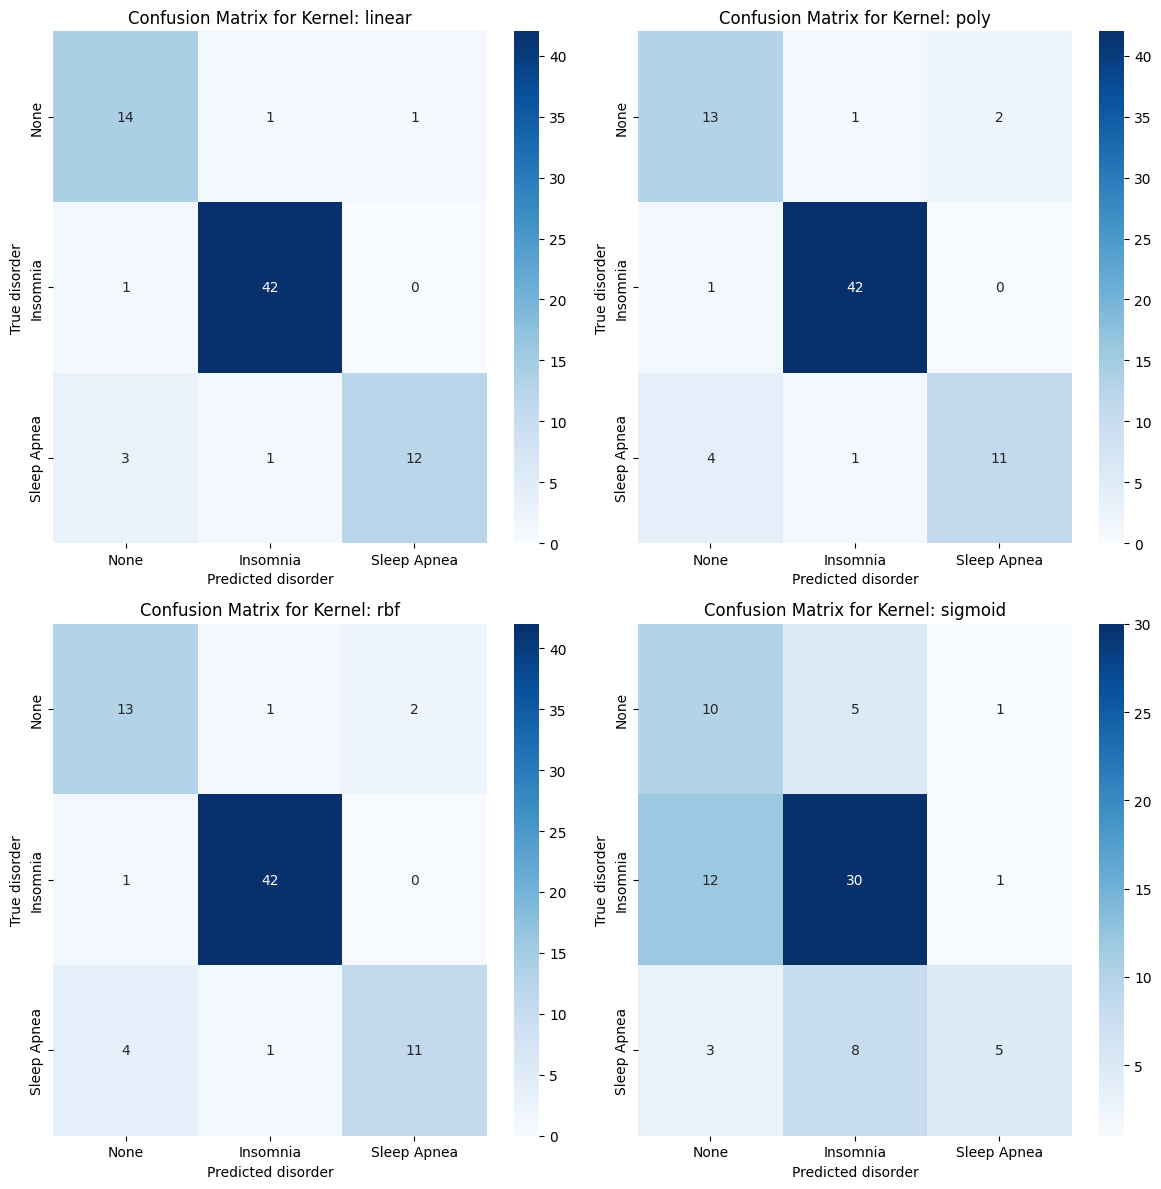

In [ ]:
from sklearn.svm import SVC

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

for idx, kernel in enumerate(kernels):
    row = idx // 2
    col = idx % 2

    svm = SVC(kernel=kernel)

    svm.fit(X_train_scaled, y_train)

    y_pred_svm = svm.predict(X_test_scaled)

    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
    recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
    f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

    print("\nSVM Metrics for Kernel:", kernel)
    print("Accuracy:", accuracy_svm)
    print("Precision:", precision_svm)
    print("Recall:", recall_svm)
    print("F1-score:", f1_svm)
    print(classification_report(y_test, y_pred_svm))

    class_labels = ['None', 'Insomnia', 'Sleep Apnea']
    conf_matrix = confusion_matrix(y_test_original, y_pred_svm)
    sns.heatmap(conf_matrix, xticklabels=class_labels, yticklabels=class_labels, annot=True, fmt="d", cmap="Blues", ax=axes[row, col])
    axes[row, col].set_xlabel('Predicted disorder')
    axes[row, col].set_ylabel('True disorder')
    axes[row, col].set_title('Confusion Matrix for Kernel: ' + kernel)

plt.tight_layout()
plt.show()


# 4. Oversampling with SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test_scaled, y_test)

4.1. Oversampling KNN

KNN Metrics:
Accuracy: 0.8217054263565892
Precision: 0.8273809523809524
Recall: 0.8217054263565892
F1-score: 0.8169729787121092
              precision    recall  f1-score   support

    Insomnia       0.75      0.84      0.79        43
        None       0.86      0.98      0.91        43
 Sleep Apnea       0.88      0.65      0.75        43

    accuracy                           0.82       129
   macro avg       0.83      0.82      0.82       129
weighted avg       0.83      0.82      0.82       129



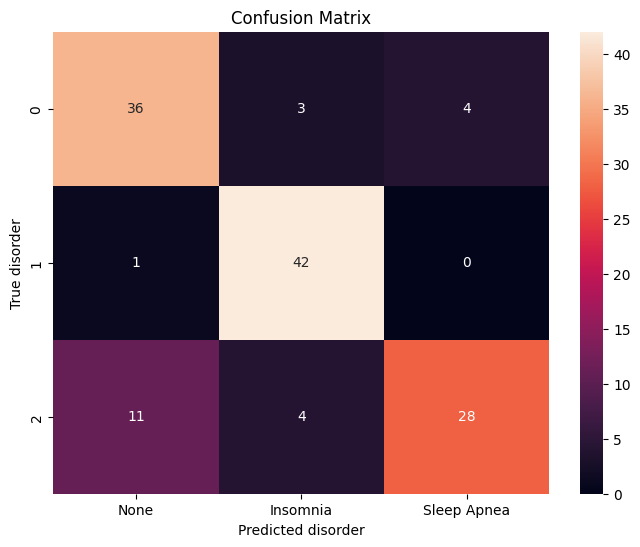

In [ ]:
scaler_knn = StandardScaler()
X_train_scaled = scaler_knn.fit_transform(X_train_resampled)
X_test_scaled = scaler_knn.transform(X_test_resampled)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train_resampled)

y_pred_knn = knn.predict(X_test_scaled)

accuracy_knn = accuracy_score(y_test_resampled, y_pred_knn)
precision_knn = precision_score(y_test_resampled, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test_resampled, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test_resampled, y_pred_knn, average='weighted')

print("KNN Metrics:")
print("Accuracy:", accuracy_knn)
print("Precision:", precision_knn)
print("Recall:", recall_knn)
print("F1-score:", f1_knn)
print(classification_report(y_test_resampled, y_pred_knn))

class_labels = ['None', 'Insomnia', 'Sleep Apnea']
conf_matrix = confusion_matrix(y_test_resampled, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=class_labels, annot=True)
plt.xlabel('Predicted disorder')
plt.ylabel('True disorder')
plt.title('Confusion Matrix')
plt.show()

4.2. Oversampling SVC


Oversampled SVM Metrics:
Accuracy: 0.8217054263565892
Precision: 0.8365501792114695
Recall: 0.8217054263565892
F1-score: 0.8196920777565939
              precision    recall  f1-score   support

    Insomnia       0.72      0.84      0.77        43
        None       0.85      0.95      0.90        43
 Sleep Apnea       0.94      0.67      0.78        43

    accuracy                           0.82       129
   macro avg       0.84      0.82      0.82       129
weighted avg       0.84      0.82      0.82       129



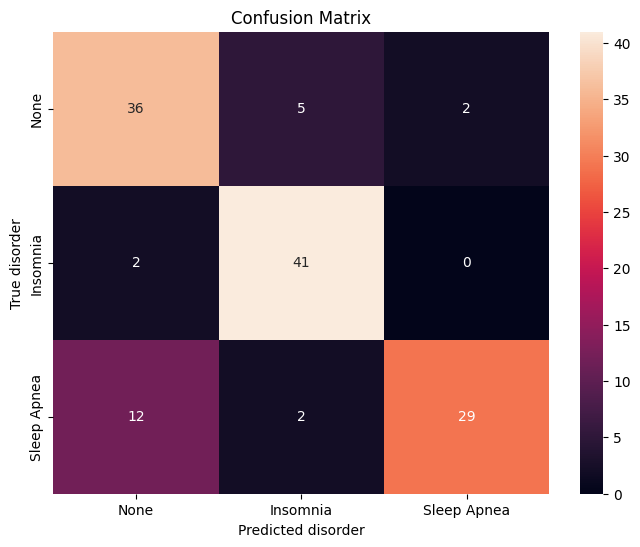

In [ ]:
svm = SVC(kernel='linear')
svm.fit(X_train_resampled, y_train_resampled)
y_pred_svm = svm.predict(X_test_resampled)

accuracy_svm = accuracy_score(y_test_resampled, y_pred_svm)
precision_svm = precision_score(y_test_resampled, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test_resampled, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test_resampled, y_pred_svm, average='weighted')

print("\nOversampled SVM Metrics:")
print("Accuracy:", accuracy_svm)
print("Precision:", precision_svm)
print("Recall:", recall_svm)
print("F1-score:", f1_svm)
print(classification_report(y_test_resampled, y_pred_svm))

# Define class labels
class_labels = ['None', 'Insomnia', 'Sleep Apnea']

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_resampled, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=class_labels, yticklabels=class_labels, annot=True)
plt.xlabel('Predicted disorder')
plt.ylabel('True disorder')
plt.title('Confusion Matrix')
plt.show()